<a href="https://colab.research.google.com/github/FreeMagic200/R_clustering/blob/main/HGC/HGC_clustering_pbmc3k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HGC: fast hierarchical clustering for large-scale single-cell data
- paper: https://academic.oup.com/bioinformatics/article/37/21/3964/6294402
- github: https://github.com/XuegongLab/HGC

micromamba env remove -n HGC_clustering

micromamba create -n HGC_clustering

mamba activate HGC_clustering

```
micromamba install -c conda-forge -c bioconda \
    r-base \
    r-biocmanager \
    r-seurat=5 \
    r-presto \
    r-seurat-data \
    r-dplyr \
    r-patchwork \
    r-remotes \
    r-devtools \
    r-irkernel \
    jupyterlab \
    python=3.9 \
    pip \
    zlib \
    liblzma \
    backports.lzma \
    r-r.utils \
    r-qs

# install zlib liblzma R.utils backports.lzma for seuratwrapper

# no seuratwrappers

> R IRkernel::installspec()

remotes::install_github('satijalab/seurat-wrappers')

BiocManager::install("HGC")

options(repos=structure(c(CRAN="https://mirrors.tuna.tsinghua.edu.cn/CRAN/")))





In [34]:
library(dplyr)
library(Seurat)
library(patchwork)
library(HGC)
library(qs)

qs 0.25.5



In [18]:
# Load the PBMC dataset
pbmc.data <- Read10X(data.dir =
                "~/Colab_Notebooks/[02] R/[03] datasets/[01] pbmc3k/filtered_gene_bc_matrices/hg19")

In [19]:
set.seed(42)
# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k",
                            min.cells = 3, min.features = 200)

# QC and selecting cells for further analysis
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 &
                nFeature_RNA < 2500 & percent.mt < 5)

# Normalizing the data
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize",
                        scale.factor = 10000)

# Identification of highly variable features (feature selection)
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst",
                                nfeatures = 2000)

# Scaling the data
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

# Perform linear dimensional reduction
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, G

In [20]:
# Determine the ‘dimensionality’ of the dataset
pbmc <- JackStraw(pbmc, num.replicate = 100)
pbmc <- ScoreJackStraw(pbmc, dims = 1:20)

In [21]:
# Construct the graph and cluster the cells with HGC
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusteringTree(pbmc, graph.type = "SNN")


Computing nearest neighbor graph

Computing SNN



In [22]:
# Output the tree
pbmc.tree <- pbmc@graphs$ClusteringTree

In [23]:
pbmc.tree


Call:
NA

Cluster method   : HGC 
Distance         : Node pair sampling ratio 
Number of objects: 2638 


[1] 1

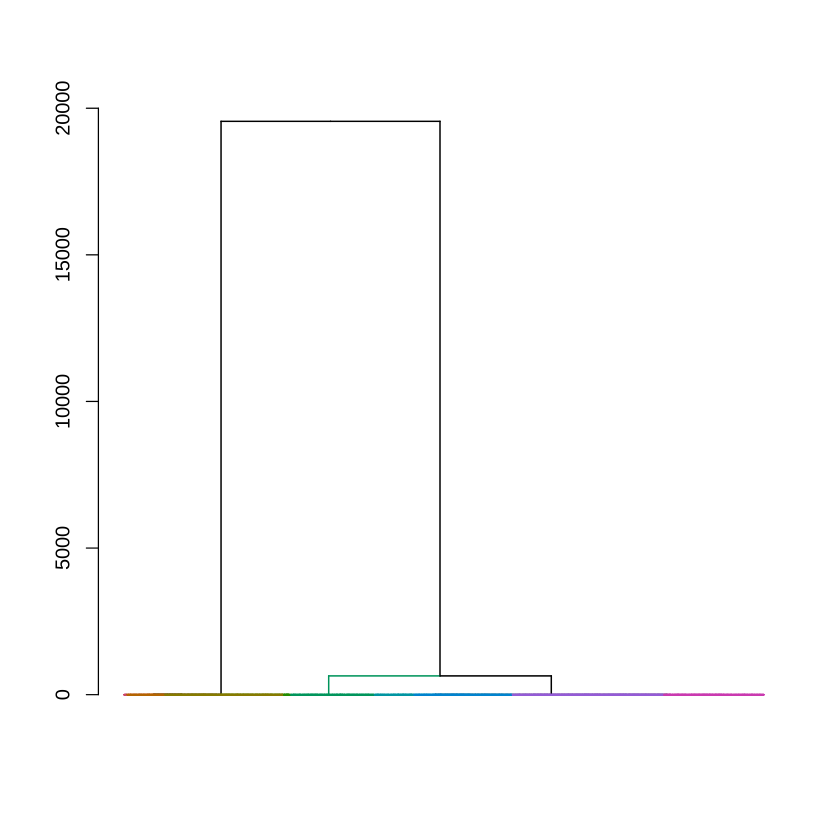

In [24]:
HGC.PlotDendrogram(tree = pbmc.tree,
                    k = 9, plot.label = FALSE)

In [25]:
cluster.assignments <- cutree(pbmc.tree, k = 9)

In [26]:
pbmc[['HGC_clusters']] <- as.factor(cluster.assignments)

In [27]:
pbmc <- RunUMAP(pbmc, dims = 1:10,verbose = F)

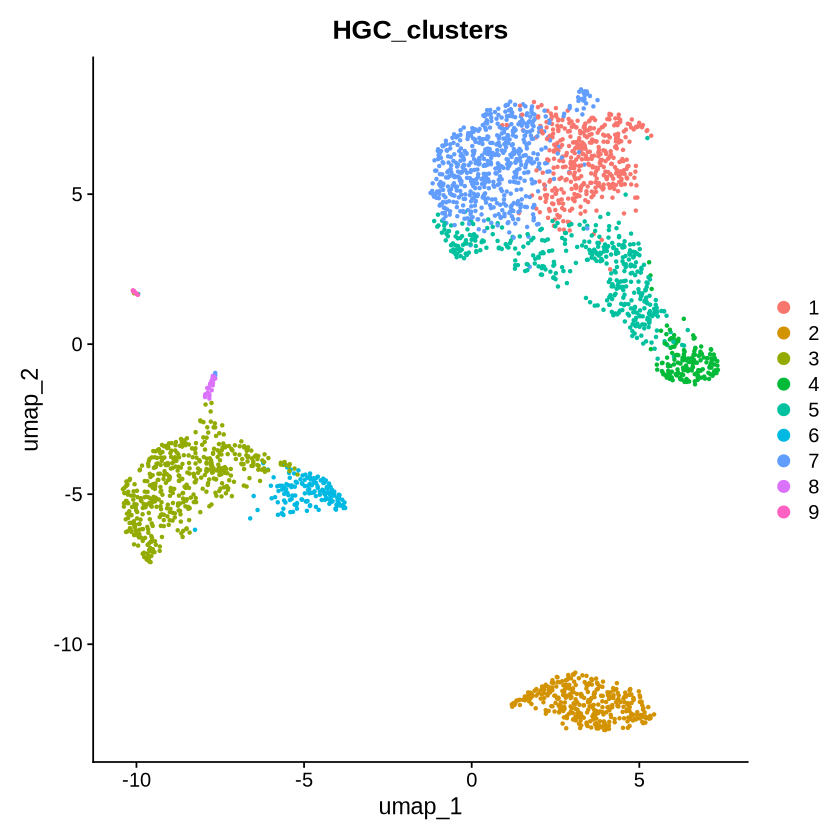

In [28]:
DimPlot(pbmc,group.by = "HGC_clusters")

![link text](https://satijalab.org/seurat/articles/pbmc3k_tutorial_files/figure-html/labelplot-1.png)

https://satijalab.org/seurat/articles/pbmc3k_tutorial


In [29]:
table(pbmc$HGC_clusters)


  1   2   3   4   5   6   7   8   9 
413 344 489 164 405 156 624  30  13 

In [30]:
Idents(pbmc) <- "HGC_clusters"

```
For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more
efficient implementation (no further action necessary).
This message will be shown once per session


In [31]:
# find markers for every cluster compared to all remaining cells, report only the positive
# ones
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE)
pbmc.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1)

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
2.118512e-84,1.275427,0.959,0.477,2.905327e-80,1,IL32
3.140461e-77,1.328404,0.978,0.653,4.306828e-73,1,LTB
7.716801e-58,1.353074,0.755,0.337,1.058282e-53,1,IL7R
4.188852e-57,3.098140,0.228,0.027,5.744592e-53,1,TNFRSF4
1.240788e-55,2.134505,0.436,0.117,1.701617e-51,1,AQP3
2.962191e-53,1.558298,0.663,0.254,4.062349e-49,1,CD2
3.797649e-52,1.059762,0.845,0.419,5.208096e-48,1,CD3E
3.325139e-37,1.943246,0.286,0.071,4.560096e-33,1,CD40LG
7.312171e-35,1.413392,0.395,0.132,1.002791e-30,1,TRAT1


In [37]:
qsave(pbmc,"~/Colab_Notebooks/[02] R/[02] clustering/[01] hierarchical clustering/[01] HGC  fast hierarchical clustering for large-scale single-cell data/pbmc_clustered.qs")

In [38]:
qsave(pbmc.tree,"~/Colab_Notebooks/[02] R/[02] clustering/[01] hierarchical clustering/[01] HGC  fast hierarchical clustering for large-scale single-cell data/pbmc_tree.qs")



```
mamba env export > HGC_conda_env.yml

installed_packages <- installed.packages()[,c("Package","Version")]
write.csv(installed_packages, "HGC_r_package_versions.csv",row.names = F)
```

